## Reference:
https://www.analyticsvidhya.com/blog/2018/10/predicting-stock-price-machine-learningnd-deep-learning-techniques-python/

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
from sklearn.metrics import *
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

In [3]:
import tensorflow as tf
from tensorflow import keras

In [100]:
df = pd.read_csv('Apple.csv',index_col=0)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1999-12-31,0.901228,0.918527,0.888393,0.917969,0.789364,163811200
2000-01-03,0.936384,1.004464,0.907924,0.999442,0.859423,535796800
2000-01-04,0.966518,0.987723,0.903460,0.915179,0.786965,512377600
2000-01-05,0.926339,0.987165,0.919643,0.928571,0.798481,778321600
2000-01-06,0.947545,0.955357,0.848214,0.848214,0.729382,767972800


In [88]:
df.shape

(4269, 6)

In [6]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-07-28,144.809998,146.970001,142.539993,144.979996,144.979996,118931200
2021-07-29,144.690002,146.550003,144.580002,145.639999,145.639999,56699500
2021-07-30,144.380005,146.330002,144.110001,145.860001,145.860001,70382000
2021-08-02,146.360001,146.949997,145.250000,145.520004,145.520004,62880000
2021-08-03,145.809998,148.039993,145.179993,147.360001,147.360001,64660800


<AxesSubplot:xlabel='Date'>

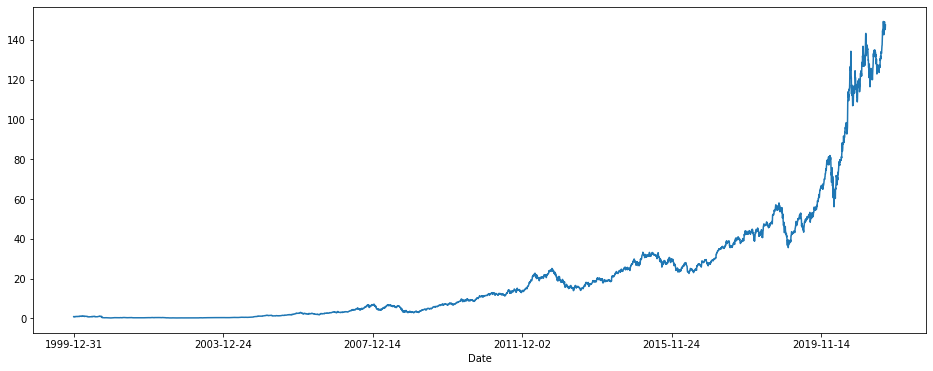

In [6]:
df['Close'].plot(figsize=(16,6))

In [7]:
df.isnull().any()

Open         False
High         False
Low          False
Close        False
Adj Close    False
Volume       False
dtype: bool

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5432 entries, 1999-12-31 to 2021-08-03
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       5432 non-null   float64
 1   High       5432 non-null   float64
 2   Low        5432 non-null   float64
 3   Close      5432 non-null   float64
 4   Adj Close  5432 non-null   float64
 5   Volume     5432 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 297.1+ KB


<AxesSubplot:xlabel='Date'>

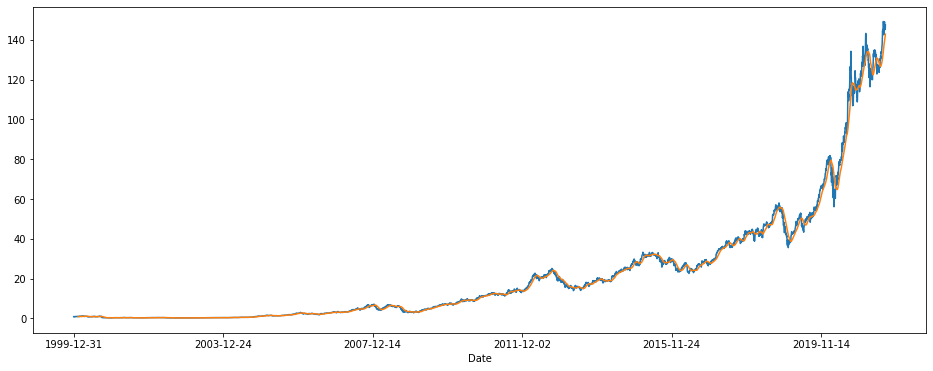

In [9]:
df['Close'].plot(figsize=(16,6))
df.rolling(30).mean()['Close'].plot(figsize=(16,6))

<AxesSubplot:xlabel='Date'>

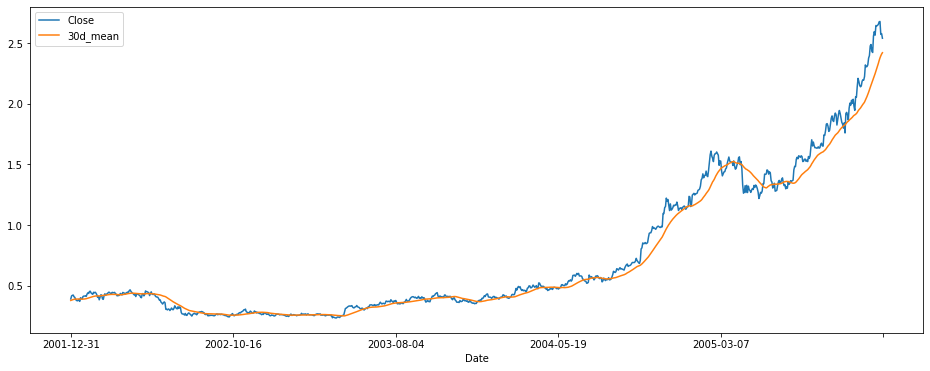

In [10]:
df['30d_mean'] = df['Close'].rolling(window=30).mean()
df.iloc[500:1500,:][['Close','30d_mean']].plot(figsize=(16,6))

In [12]:
# mean_squared_error(df.iloc[30:,:]['Close'],df.iloc[30:,:]['30d_mean'])
# mean_absolute_error(df.iloc[30:,:]['Close'],df.iloc[30:,:]['30d_mean'])

## Expanding

<AxesSubplot:xlabel='Date'>

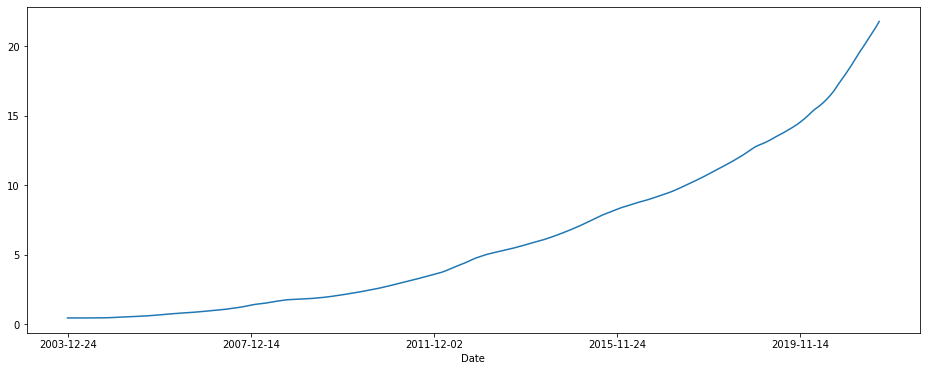

In [11]:
df['Close'].expanding(min_periods=1000).mean().plot(figsize=(16,6))

## Data Preprocessing:

In [89]:
series = df['Close'].values
split_time = int(len(series)*0.8)
train = series[:split_time]
test  = series[split_time:]

series = np.array(series).reshape(-1,1)
scaler = MinMaxScaler(feature_range=(0,1))
series_scaled = scaler.fit_transform(series)
series

array([[  49.98265457],
       [  53.95277023],
       [  54.49573517],
       ...,
       [2704.41992188],
       [2719.79003906],
       [2725.60009766]])

In [90]:
X_train = []
y_train = []
for i in range(60,len(train)):
    X_train.append(series_scaled[i-60:i,0])
    y_train.append(series_scaled[i,0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))
print(X_train.shape)

(3355, 60, 1)


In [91]:
## test data
test_data = series[len(series)-len(test)-60:]
test_data = test_data.reshape(-1,1)
test_data = scaler.transform(test_data)

X_test = []
for i in range(60,len(test_data)):
    X_test.append(test_data[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
print(X_test.shape)

(854, 60, 1)


In [92]:
X_train[0][:10]

array([[5.99279828e-05],
       [1.50725281e-03],
       [1.70519330e-03],
       [8.82561335e-04],
       [1.08776527e-03],
       [1.43461414e-03],
       [1.11500425e-03],
       [3.63193364e-04],
       [4.28568587e-04],
       [4.35834818e-05]])

In [93]:
X_test[0][:10]

array([[0.36431122],
       [0.36979409],
       [0.3745151 ],
       [0.37216009],
       [0.37007115],
       [0.36958996],
       [0.36831037],
       [0.36707817],
       [0.36439141],
       [0.36394301]])

## Training Neural Network model

In [30]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

In [94]:
# Initialising the RNN
model = Sequential()

# Adding the first LSTM layer and some Dropout regularisation 
model.add(LSTM(units=64, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(Dropout(0.1))

# Adding the second LSTM layer and some Dropout regularisation 
model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(0.1))

# Adding the third LSTM layer and some Dropout regularisation 
model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(0.1))

# Adding the third LSTM layer and some Dropout regularisation 
model.add(LSTM(units=32))
model.add(Dropout(0.1))
# output layer
model.add(Dense(units=16))
model.add(Dense(units=1))

In [95]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 60, 64)            16896     
_________________________________________________________________
dropout_12 (Dropout)         (None, 60, 64)            0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 60, 64)            33024     
_________________________________________________________________
dropout_13 (Dropout)         (None, 60, 64)            0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 60, 64)            33024     
_________________________________________________________________
dropout_14 (Dropout)         (None, 60, 64)            0         
_________________________________________________________________
lstm_15 (LSTM)               (None, 32)               

In [96]:
model.compile(optimizer='adam',loss='mean_squared_error',metrics=['mae'])
model.fit(X_train,y_train, epochs=10, batch_size=32,verbose=2)

Epoch 1/10
105/105 - 20s - loss: 0.0012 - mae: 0.0192
Epoch 2/10
105/105 - 14s - loss: 1.9868e-04 - mae: 0.0100
Epoch 3/10
105/105 - 12s - loss: 1.6171e-04 - mae: 0.0088
Epoch 4/10
105/105 - 11s - loss: 1.5120e-04 - mae: 0.0086
Epoch 5/10
105/105 - 11s - loss: 1.3144e-04 - mae: 0.0080
Epoch 6/10
105/105 - 11s - loss: 1.3736e-04 - mae: 0.0085
Epoch 7/10
105/105 - 11s - loss: 1.2184e-04 - mae: 0.0078
Epoch 8/10
105/105 - 11s - loss: 1.1360e-04 - mae: 0.0076
Epoch 9/10
105/105 - 10s - loss: 1.0616e-04 - mae: 0.0073
Epoch 10/10
105/105 - 11s - loss: 1.1377e-04 - mae: 0.0076


In [97]:
# Model Prediction
y_pred = model.predict(X_test)
#print(y_pred[:10])
y_pred = scaler.inverse_transform(y_pred)
#print(y_pred[:10])

# Moving averages
y_mv = df.iloc[split_time-60:,0].rolling(60).mean()[60:].values.reshape(-1,1)
#print(y_mv[:10])
#print(test[:10])

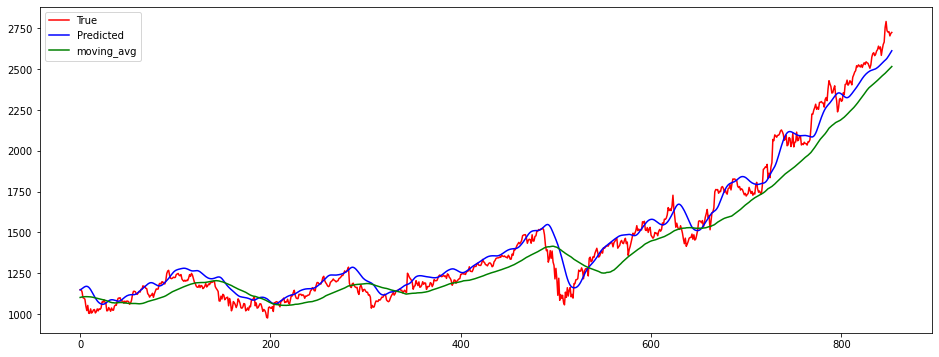

In [98]:
plt.figure(figsize=(16,6))
x_axis = np.arange(y_pred.shape[0])

plt.plot(x_axis,test, c='r',label='True')
plt.plot(x_axis,y_pred,c='b',label='Predicted')
plt.plot(x_axis,y_mv,c='g',label='moving_avg')
plt.legend()
plt.show()

In [99]:
mean_absolute_error(test,y_pred),mean_absolute_error(test,y_mv)

(54.6366880894824, 92.61427460788843)